<a href="https://colab.research.google.com/github/rnklee/ultrasound-nerve-segmentation/blob/main/nerve_segmentation_practice_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip install torchmetrics
! pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=d3571a812207dfb3292167f0baea04bd0f29566fe728dd6445ef67c96d8b3b37
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9f6866bfb85dd6b047455d8d08ba5

In [3]:
import sys, os
import re
import time
import pickle

In [4]:
from tqdm import tqdm

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from skimage.metrics import structural_similarity as ssim

from PIL import Image
import cv2

import random

from itertools import combinations

from collections import OrderedDict
from functools import partial

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

from torch.utils.data import Dataset, DataLoader, sampler

import torchmetrics

import torchvision
from torchvision import transforms, models

import segmentation_models_pytorch as smp
import albumentations

import segmentation_models_pytorch.utils.metrics
import segmentation_models_pytorch.utils.losses

# Load the data

In [7]:
def to_img(msk):
    return msk.replace('_mask', '')

In [8]:
ultrasoundpath = '/content/drive/MyDrive/ultrasound-nerve-segmentation'
trainpath = '/content/drive/MyDrive/ultrasound-nerve-segmentation/train'
testpath = '/content/drive/MyDrive/ultrasound-nerve-segmentation/test'

In [ ]:
masks = [os.path.join(trainpath,i) for i in os.listdir(trainpath) if "mask" in i]
masks = [o for o in masks if '(' not in o] # get rid of duplicates that were somehow created during uploading.
images = [to_img(mask) for mask in masks]

# Examining the data

In [ ]:
len(masks)

5635

In [ ]:
cv2.imread(images[0], cv2.IMREAD_GRAYSCALE).shape

(420, 580)

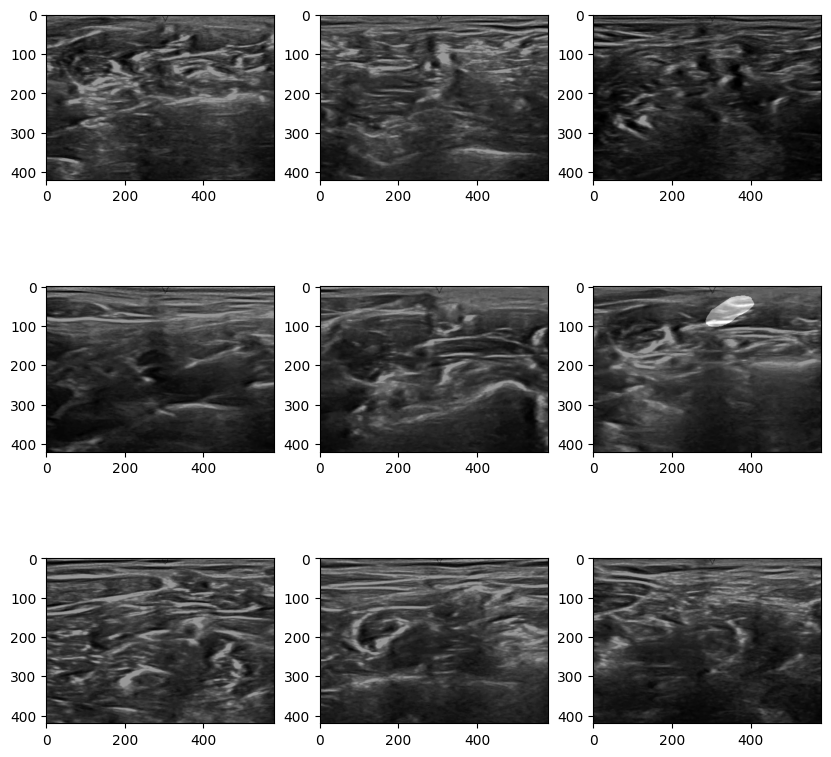

In [ ]:
rows, cols = 3, 3
fig = plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(images))
    fig.add_subplot(rows,cols,i)
    img_path = images[ii]
    msk_path = masks[ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path)), alpha=0.4, cmap = 'gray')
plt.show()

## Removing duplicates
Here I just remove duplicate images with conflicting masks (one with nerves, one without nerves) and remove the image, mask pairs with missing nerves ([source](https://www.kaggle.com/code/agalea91/mislabeled-training-images/notebook)). Unlike the source, I use ssim on scaled images to determine whether two images are the same (as in this [article](https://medium.com/analytics-vidhya/ultrasound-nerve-segmentation-an-end-to-end-image-segmentation-case-study-ec88bfed0894)).

In [ ]:
with open(ultrasoundpath + 'dup_dict.pkl', 'rb') as f:
    dup_dict = pickle.load(f)

In [ ]:
img1, img2 = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE), cv2.imread(images[1], cv2.IMREAD_GRAYSCALE)

start = time.time()
temp1, temp2 = cv2.resize(img1, (64,64)), cv2.resize(img2, (64,64))
ssim(temp1, temp2)
end = time.time()

resize_time = end-start

start = time.time()
ssim(img1, img2)
end = time.time()

no_resize_time = end-start

print(resize_time, no_resize_time)

0.016856908798217773 0.02540874481201172


In [ ]:
def find_dups(images):
    imgs = []
    pairs = []

    for i in tqdm(range(len(masks))):
        imgs.append(cv2.imread(images[i], cv2.IMREAD_GRAYSCALE))

    for i, j in tqdm(combinations(range(len(masks)), 2)):
        img1 = cv2.resize(imgs[i], (64,64))
        img2 = cv2.resize(imgs[j], (64,64))

        sim = ssim(img1, img2)
        if abs(sim) >= 0.99:
            if i < j:
                pairs.append((i,j))
            else:
                pairs.append((j,i))

    return pairs

In [ ]:
dup_pairs = find_dups(images)

100%|██████████| 5635/5635 [00:36<00:00, 154.75it/s]
15873795it [1:46:21, 2487.36it/s]


In [ ]:
with open(ultrasoundpath + 'dup_pairs_1.pkl', 'wb') as f:
    pickle.dump(dup_pairs, f)

In [ ]:
new_dict = {}
to_remove = []
for k in tqdm(dup_dict.keys()):
    non_trivial = []
    trivial = []
    for v in dup_dict[k]:
        m = cv2.imread(masks[v], cv2.IMREAD_GRAYSCALE)
        if m.any(): non_trivial.append(v)
        else: trivial.append(v)

    if len(non_trivial):
        new_dict[k] = non_trivial
        to_remove += trivial
    # else:
    #     to_remove += trivial[1:]

dup_dict = new_dict
dup_keys = list(dup_dict.keys())

100%|██████████| 45/45 [00:00<00:00, 115.04it/s]


In [ ]:
len(dup_keys), len(to_remove), len(list(set(to_remove)))

(37, 16, 12)

In [ ]:
dup_dict

{142: [142, 183],
 155: [155, 264],
 170: [170, 229],
 186: [186, 265],
 218: [218, 239],
 226: [226, 243],
 325: [333],
 339: [339],
 2691: [2693, 2714],
 2693: [2693, 2714],
 2714: [2714],
 2797: [2797, 2809],
 3019: [3019, 3907, 3985],
 3197: [3197, 3198],
 3207: [3207, 3228],
 3315: [3315, 3353],
 3344: [3344, 3364],
 3504: [4442],
 3907: [3907, 3985],
 3911: [3911, 3969],
 3939: [3939, 3954],
 4061: [4061, 4958],
 4255: [4255, 4294],
 4300: [4376],
 4389: [4389, 4403],
 4513: [4513],
 4572: [4637],
 4580: [4580, 4603],
 4602: [4602, 4697],
 4758: [4758, 4879],
 4783: [4783],
 4817: [4817, 4876],
 5025: [5025, 5616],
 5111: [5111, 5136],
 5113: [5616],
 5136: [5136],
 5498: [5498]}

In [ ]:
dice_score = lambda m1, m2: (2.0*np.multiply(m1,m2).sum()+1)/ (m1.sum()+m2.sum()+1)

dice_dict = {}
for k, v in tqdm(dup_dict.items()):
    dice_dict[k] = []
    for i, j in combinations(dup_dict[k], 2):
        m1 = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)//255
        m2 = cv2.imread(masks[j], cv2.IMREAD_GRAYSCALE)//255
        dice_dict[k].append(dice_score(m1, m2))

100%|██████████| 345/345 [00:14<00:00, 23.76it/s]


In [ ]:
for i, k in enumerate(dup_keys):
    if len(dice_dict[k]) > 1 and np.std(dice_dict[k]) >= 0.1:
        print(k, len(dup_dict[k]), np.mean(dice_dict[k]), np.std(dice_dict[k]))

4235 5 0.6665115654101551 0.16341898018990414
5328 5 0.7213736650381186 0.12802691859270288
4238 4 0.639972073149648 0.14756042410256118
5347 4 0.6917157088764604 0.1523244185403698
381 3 0.7207221417427966 0.13257192716642946
3344 3 0.694587753356758 0.10276596779946343
5361 3 0.6954890471926084 0.1524861303781563


5it [00:00, 53.33it/s]


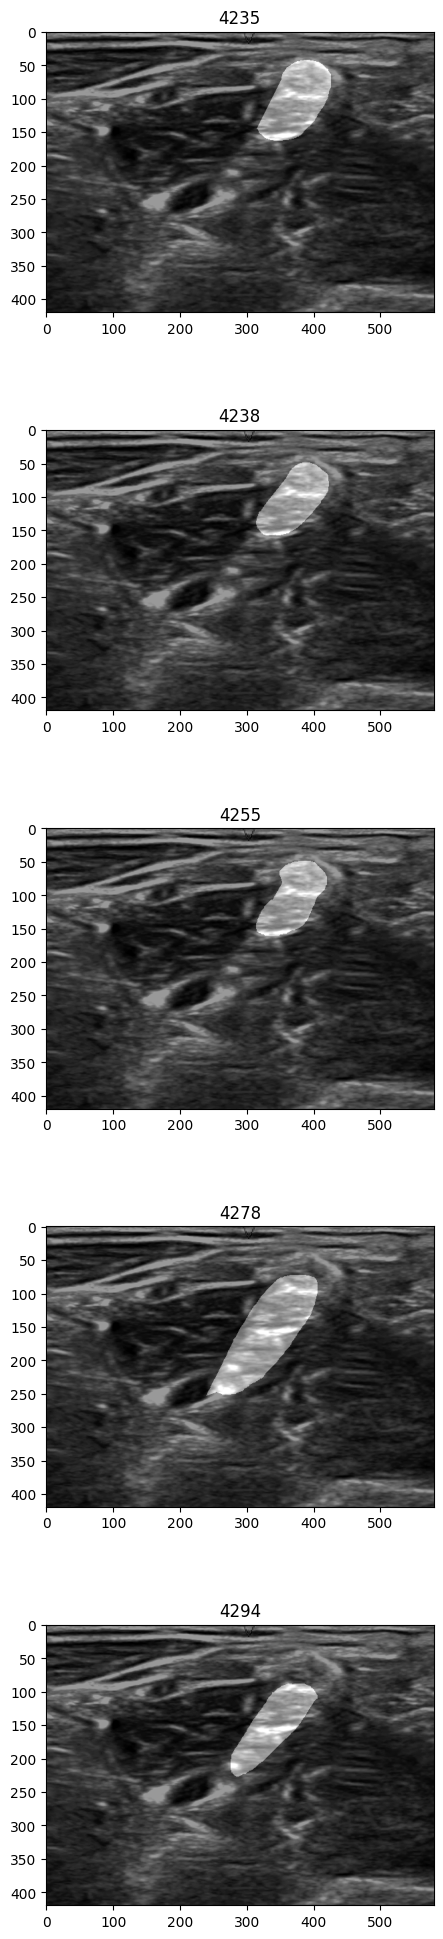

In [ ]:
k = 4235

fig, axes = plt.subplots(len(dup_dict[k]), figsize = (5, 5*(len(dup_dict[k]))))

for i, o in tqdm(enumerate(dup_dict[k])):
    axes[i].imshow(np.array(Image.open(images[o])), cmap = 'gray')
    axes[i].imshow(np.array(Image.open(masks[o])), alpha=0.4, cmap = 'gray')
    axes[i].title.set_text(o)

plt.show()

In [ ]:
def find_duplicates(images, masks):
    pairs = []

    msks = []
    imgs = []
    for i in tqdm(range(len(masks))):
        msks.append(cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE))
        imgs.append(cv2.imread(images[i], cv2.IMREAD_GRAYSCALE))

    for i in tqdm(range(len(masks))):
        msk1 = msks[i]
        img1 = cv2.resize(imgs[i], (64,64))
        for j in range(i+1, len(masks)):
            msk2 = msks[j]
            img2 = cv2.resize(imgs[j], (64,64))

            sim = ssim(img1, img2)
            if abs(sim) > 0.99 and msk1.any() != msk2.any():
                pairs.append((i,j))
    return pairs

In [ ]:
dup_pairs = find_duplicates(images, masks)

100%|██████████| 5635/5635 [2:41:47<00:00,  1.72s/it]


In [ ]:
def find_dups(images):
    imgs = []
    pairs = {}

    for i in tqdm(range(len(masks))):
        imgs.append(cv2.imread(images[i], cv2.IMREAD_GRAYSCALE))

    for i in tqdm(range(len(masks))):
        for j in range(i+1, len(masks)):
            if not (imgs[i]-imgs[j]).any():
                if i not in pairs:
                    pairs[i] = [i]
                pairs[i].append(j)

    return pairs

In [ ]:
dup_dict = find_dups(images)

100%|██████████| 5635/5635 [14:21<00:00,  6.54it/s] 


In [ ]:
with open(ultrasoundpath + 'dup_pairs.pkl', 'wb') as f:
    pickle.dump(dup_pairs, f)

In [ ]:
with open(ultrasoundpath + 'dup_pairs.pkl', 'rb') as f:
    dup_pairs = pickle.load(f)

In [ ]:
to_remove = []
for pair in tqdm(dup_pairs):
    i1, i2 = pair
    msk1 = cv2.imread(masks[i1], cv2.IMREAD_GRAYSCALE)
    if msk1.any():
        to_remove.append(masks[i1])
    else:
        to_remove.append(masks[i2])
to_remove = list(set(to_remove))

100%|██████████| 262/262 [03:17<00:00,  1.33it/s]


In [ ]:
len(dup_pairs), len(to_remove) #?!

(262, 139)

In [ ]:
masks = [o for o in masks if o not in to_remove]
images = [to_img(mask) for mask in masks]

In [9]:
with open(ultrasoundpath + 'cleaned_masks.pkl', 'rb') as f:
    masks = pickle.load(f)

with open(ultrasoundpath + 'cleaned_images.pkl', 'rb') as f:
    images = pickle.load(f)

with open(ultrasoundpath + 'cleaned_strat.pkl', 'rb') as f:
    stratify = pickle.load(f)

In [ ]:
len(masks), len(images), len(stratify)

(5496, 5496, 5496)

In [ ]:
masks[:10]

['/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_74_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_91_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_87_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_96_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/6_100_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_88_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_8_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_98_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_84_mask.tif',
 '/content/drive/MyDrive/ultrasound-nerve-segmentation/train/5_97_mask.tif']

## Checking the size of nerves

In [ ]:
sizes = []
for o in tqdm(masks):
    mask = cv2.imread(o, cv2.IMREAD_GRAYSCALE)/255
    sizes.append(mask.sum())

100%|██████████| 5496/5496 [15:14<00:00,  6.01it/s]


In [ ]:
np.mean([s for s in sizes if s])/(420*580), np.std([s for s in sizes if s])/(420*580)

(0.029254266361717098, 0.007355513332276897)

In [ ]:
stratify = [1 if s else 0 for s in sizes ]

In [ ]:
with open(ultrasoundpath + 'cleaned_strat.pkl', 'wb') as f:
    pickle.dump(stratify, f)

# Useful definitions

In [10]:
def has_nerve(mask):
    o = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    return 1 if o.any() else 0

In [11]:
def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')

In [15]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight = 1, soft=True):
        super().__init__()
        self.__name__ = 'BCE + dice'
        self.weight = weight

    def forward(self, output, target):
        bce = nn.BCELoss()
        dice = smp.utils.losses.DiceLoss()
        return bce(output, target) + self.weight*dice(output, target)


class HardDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.__name__ = 'hard_dice'

    def forward(self, output, target):
        dice = smp.utils.losses.DiceLoss()
        return dice(output.round(), target)


BCELoss = nn.BCELoss()
BCELoss.__name__ = 'BCE'

In [16]:
class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module from https://gist.github.com/rwightman/f2d3849281624be7c0f11c85c87c1598

    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding

    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd,
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [17]:
class NerveDataset(Dataset):
    def __init__(self, mskfiles, color=True, preprocess=None, augment=None, train=True):
        super().__init__()

        self.mskfiles = mskfiles
        self.imgfiles = [o.replace('_mask', '') for o in mskfiles]

        self.preprocess = preprocess
        self.augment = augment
        self.color = color


    def __len__(self):
        return len(self.mskfiles)


    def __getitem__(self, idx):
        msk = cv2.imread(self.mskfiles[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(self.imgfiles[idx], cv2.IMREAD_GRAYSCALE)

        if self.color:
            img = cv2.imread(self.imgfiles[idx])
        else:
            img = cv2.imread(self.imgfiles[idx], cv2.IMREAD_GRAYSCALE)

        msk = cv2.imread(self.mskfiles[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment is not None:
            sample = self.augment(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if self.preprocess is not None:
            sample = self.preprocess(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if not self.color:
            img = np.expand_dims(img, axis=0)
        img = img.astype(np.float32)
        msk = (msk/255).astype(np.float32)
        msk = np.expand_dims(msk, axis=0)

        return img, msk

In [24]:
def _format_logs(self, logs):
    # From segmentation_models.pytorch/segmentation_models_pytorch/utils/train.py
    str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
    s = ", ".join(str_logs)
    return s


def train_validate(train_msks, valid_msks, preprocess, augment, model, optim,
                   color=True, loss=DiceBCELoss(), metrics=[smp.utils.losses.DiceLoss()],
                   device='cuda', batch_size=16, epochs=5, stopper=None,
                   save_thres=1e6, save_metric='dice', save_file=None):

    traindata = NerveDataset(mskfiles=train_msks, color=color, preprocess=preprocess, augment=augment)
    validdata = NerveDataset(mskfiles=valid_msks, color=color, preprocess=preprocess)

    trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
    validloader = DataLoader(validdata, batch_size = batch_size, shuffle = True)

    trainepoch = smp.utils.train.TrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics, verbose=False)
    validepoch = smp.utils.train.ValidEpoch(model, device=device, loss=loss, metrics=metrics, verbose=False)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

    train_valid_log = pd.DataFrame(columns=['train', 'valid'])

    for i in (epoch_bar := tqdm(range(epochs))):

        trainlogs = trainepoch.run(trainloader)
        validlogs = validepoch.run(validloader)

        for metric in metrics:
            train_loss = trainlogs[metric.__name__]
            valid_loss = validlogs[metric.__name__]
            train_valid_log.loc[len(train_valid_log)] = {'metic': metric.__name__, 'train': train_loss, 'valid': valid_loss}

        epoch_str = f'Epoch {i}: train loss: {train_loss}, valid_loss {valid_loss}'
        epoch_bar.set_postfix_str(epoch_str)

        if stopper is not None and stopper.early_stop(valid_loss):
            break

        lr_scheduler.step()

    return train_valid_log


def cross_validate(mskfiles, augment, preprocess, model, optim,
                   color=True, loss= DiceBCELoss(), metric=smp.utils.losses.DiceLoss(),
                   device='cuda', batch_size=16, epochs=5, n_splits=8):

    folds = StratifiedKFold(n_splits=n_splits, shuffle=True).split(mskfiles, stratify)

    loss_log = pd.DataFrame(columns=['train', 'valid'])
    for i, (train_idxs, valid_idxs) in enumerate(folds):
        print('\nFold: {}'.format(i))

        train_msks, valid_msks = mskfiles[train_idxs], mskfiles[valid_idxs]
        train_valid_log = train_validate(train_msks, valid_msks, preprocess, augment, model, optim,
                                                color, loss, metric, device, batch_size, epochs)

        loss_log.loc[i] = train_valid_log[train_valid_log.valid == train_valid_log.valid.min()]

    return loss_log


def split_train_validate(maskfiles, augment, preprocess, model, optim,
                            color=True, loss= DiceBCELoss(), metrics=[smp.utils.losses.DiceLoss()],
                            device='cuda', batch_size=16, epochs=5, val_size=0.15):

    train_msks, valid_msks = train_test_split(maskfiles, test_size=val_size, stratify=stratify)
    train_valid_log = train_validate(train_msks, valid_msks, color, preprocess, augment, model, optim, loss, metrics,
                                            device, batch_size, epochs)
    return train_valid_log

In [19]:
class EarlyStopper:
    "From https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch."
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Create train/validation/test set

In [25]:
train_test_msks, _ = train_test_split(masks, test_size = 0.5, stratify=stratify) # I'll use only a subset of the dataset since GPU usage is limited.
train_test_stratify = [has_nerve(o) for o in train_test_msks]
train_msks, test_msks = train_test_split(train_test_msks, test_size = 0.15, stratify=train_test_stratify)
train_stratify = [has_nerve(o) for o in train_msks]
train_msks, valid_msks = train_test_split(train_msks, test_size = 0.15, stratify=train_stratify)

In [27]:
datapath = ultrasoundpath + '/data'

with open(datapath + '/train_test_msks.pkl', 'wb') as f:
    pickle.dump(train_test_msks, f)
with open(datapath + '/train_test_stratify.pkl', 'wb') as f: # Let's save this just in case.
    pickle.dump(train_test_stratify, f)
with open(datapath + '/train_msks.pkl', 'wb') as f:
    pickle.dump(train_msks, f)
with open(datapath + '/valid_msks.pkl', 'wb') as f:
    pickle.dump(valid_msks, f)

# Pre-trained models

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [30]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
optim = torch.optim.Adam([dict(params=model.parameters(), lr=1e-3)])

augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])
preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

imagenet34 = train_validate(train_msks, valid_msks, color=True, augment=augment, preprocess=preprocess,
                       model=model, optim=optim, loss=DiceBCELoss(), metric=smp.utils.losses.DiceLoss(),
                       device='cuda', batch_size=16, epochs=5)

  0%|          | 0/5 [00:10<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
encoder = 'resnet18'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
encoder = 'resnet18'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
optim = torch.optim.Adam([dict(params=model.parameters(), lr=1e-3)])

augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])
preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

imagenet18_train, imagenet18_valid = NerveTrainValid.fit(color=True, model=model, optim=optim, augment=augment, preprocess=preprocess,
                                                         batch_size = 16, epochs = 30)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]



Epoch: 0
valid: 100%|██████████| 53/53 [00:13<00:00,  4.04it/s, BCE + dice - 0.5058, BCE - 0.05188, dice_loss - 0.4539]

Epoch: 1
valid: 100%|██████████| 53/53 [00:11<00:00,  4.56it/s, BCE + dice - 0.4781, BCE - 0.0427, dice_loss - 0.4354]

Epoch: 2
valid: 100%|██████████| 53/53 [00:11<00:00,  4.61it/s, BCE + dice - 0.4415, BCE - 0.03856, dice_loss - 0.403]

Epoch: 3
train:  63%|██████▎   | 190/300 [01:05<00:42,  2.58it/s, BCE + dice - 0.4841, BCE - 0.04544, dice_loss - 0.4387]

# A simpler ResNetUNet

In [ ]:
class Conv2dAuto(nn.Conv2d):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.padding = (self.kernel_size[0]//2, self.kernel_size[1]//2)



def conv_bn(inplanes, planes, kernel_size=3, stride=1, *args, **kwargs):
    conv = partial(Conv2dAuto, kernel_size=kernel_size, stride=stride, bias=False)
    return nn.Sequential(OrderedDict(
        {
            'conv' : conv(inplanes, planes, *args, **kwargs),
            'bn' : nn.BatchNorm2d(planes)
        }
    ))

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

In [ ]:
# ResNet implementation adopted from https://github.com/FrancescoSaverioZuppichini/ResNet.
class ResNetBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, expansion=1, downsampling=1, *args, **kwargs):
        super().__init__()
        self.inplanes, self.planes = inplanes, planes
        self.expansion, self.downsampling = expansion, downsampling

        self.blocks = nn.Identity()
        self.shortcut = nn.Sequential(OrderedDict(
            {
                'conv_bn' : conv_bn(self.inplanes, self.expansion * self.planes, kernel_size=1, stride=self.downsampling)
            }
        )) if self.inplanes != self.expansion * self.planes else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x



class ResNetBasicBlock(ResNetBlock):
    def __init__(self, inplanes, planes, kernel_size=3, activation=nn.ReLU, *args, **kwargs):
        super().__init__(inplanes, planes, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.inplanes, self.planes, kernel_size=kernel_size, stride=self.downsampling),
            activation(),
            conv_bn(self.planes, self.expansion * self.planes, kernel_size=kernel_size)
        )



class ResNetBottleneckBlock(ResNetBlock):
    expansion = 4
    def __init__(self, inplanes, planes, kernel_size=3, activation=nn.ReLU, *args, **kwargs):
        super().__init__(inplanes, planes, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.inplanes, self.planes, kernel_size=1),
            activation(),
            conv_bn(self.planes, self.planes, kernel_size=kernel_size, stride=self.downsampling),
            activation(),
            conv_bn(self.planes, self.expansion * self.planes, kernel_size=1)
        )



class ResNetLayer(nn.Module):
    def __init__(self, inplanes, planes, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        self.downsampling = 2 if inplanes != planes else 1

        self.blocks = nn.Sequential(
            block(inplanes, planes, *args, **kwargs, downsampling=self.downsampling),
            *[block(block.expansion * planes, block.expansion * planes, downsamplig=1, *args, **kwargs) for _ in range(n-1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x



class ResNetEncoder(nn.Module):
    # no stem if stem_size=0
    def __init__(self, inplanes=3, stem_size=64, block_sizes=[64,128,256,512], depths=[2,2,2,2],
                 activation=nn.ReLU, block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.out_channels = [stem_size] + block_sizes if stem_size else block_sizes

        if stem_size:
            self.stem = nn.Sequential(
                conv_bn(inplanes, stem_size, kernel_size=7, stride=2),
                activation(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
            inplanes = stem_size

        else:
            self.stem = nn.Identity()

        in_out_planes = list(zip(block_sizes[:-1], block_sizes[1:]))
        self.layers = nn.ModuleList([
            ResNetLayer(inplanes, block_sizes[0], n=depths[0], activation=activation, block=block, *args, **kwargs),
            *[ResNetLayer(inplanes*block.expansion, planes, n=n, activation=activation, block=block, *args, **kwargs)
            for (inplanes, planes), n in zip(in_out_planes, depths[1:])]
        ])

        downsampling = [layer.downsampling for layer in self.layers]
        self.downsampling = [4] + downsampling if stem_size else downsampling


    def forward(self, x):
        x = self.stem(x)
        outputs = [x]
        for layer in self.layers:
            x = layer(x)
            outputs = [x] + outputs
        return outputs

In [ ]:
# UNet implementation adopted from smp source code.
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, skip_channel, out_channel):
        super().__init__()
        self.in_channel, self.skip_channel, self.out_channel = in_channel, skip_channel, out_channel
        self.blocks = nn.Sequential(
            conv_bn(in_channel + skip_channel, out_channel),
            conv_bn(out_channel, out_channel)
        )

    def forward(self, x, skip=None, scale_factor=1):
        if self.skip_channel:
            scale_factor = skip.shape[2]//x.shape[2]
            x = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
            x = torch.cat([x, skip], dim=1)
        else:
            x = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
        x = self.blocks(x)
        return x



class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()

        skip_channels = list(encoder_channels[1:]+[0])
        in_channels = decoder_channels[:-1]
        out_channels = decoder_channels[1:]
        blocks = [
            DecoderBlock(in_channel, skip_channel, out_channel)
            for in_channel, skip_channel, out_channel in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):
        x = features[0]
        skips = features[1:]
        for i, decoder_block in enumerate(self.blocks):
            if i < len(skips):
                x = decoder_block(x, skip=skips[i])
            else:
                x = decoder_block(x, skip=None, scale_factor=4)
        return x

In [ ]:
class UNet(nn.Module):
    # For this simplified decoder, just assume decoder reduces the channels by two at all layers,
    # with the last layer outputting 16 channels.
    def __init__(self, encoder, activation=nn.Sigmoid, postprocessing=nn.Identity):
        super().__init__()

        self.encoder = encoder

        encoder_channels = encoder.out_channels[::-1]
        decoder_channels = [encoder_channels[0]//(2**i) for i in range(len(encoder_channels)+1)]
        self.decoder = UNetDecoder(encoder_channels, decoder_channels)
        self.segmentation_head = nn.Sequential(OrderedDict(
            {
                'conv_bn':  conv_bn(decoder_channels[-1], 1),
                'activation': activation(),
                'post-processing': postprocessing()
            }
        ))


    def forward(self, x):
        features = self.encoder(x)
        decoder_output = self.decoder(*features)
        masks = self.segmentation_head(decoder_output)

        return masks

In [ ]:
scratch_resnet = ResNetEncoder(inplanes=1, stem_size=64, block_sizes=[64,128,256,512], depths=[2,2,2,2], activation=nn.ReLU, block=ResNetBasicBlock)
scratch_model = UNet(encoder=scratch_resnet)
scratch_model

UNet(
  (encoder): ResNetEncoder(
    (stem): Sequential(
      (0): Sequential(
        (conv): Conv2dAuto(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layers): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-

In [ ]:
optim = torch.optim.Adam([dict(params=scratch_model.parameters(), lr=1e-2)])

augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])
preprocess = albumentations.Compose([albumentations.Resize(height=256, width=256, interpolation=Image.BILINEAR),
                                     albumentations.Normalize(mean=0.5, std=0.25)])

scratch_train, scratch_valid = NerveTrainValid.fit(color=False, model=scratch_model, optim=optim,
                                                   augment=augment, preprocess=preprocess, batch_size = 16, epochs = 20)


Epoch: 0
valid: 100%|██████████| 71/71 [00:13<00:00,  5.17it/s, BCE + dice - 1.096, BCE - 0.2203, dice_loss - 0.8757]

Epoch: 1
valid: 100%|██████████| 71/71 [00:13<00:00,  5.34it/s, BCE + dice - 0.8406, BCE - 0.04841, dice_loss - 0.7921]

Epoch: 2
valid: 100%|██████████| 71/71 [00:13<00:00,  5.28it/s, BCE + dice - 0.6069, BCE - 0.04981, dice_loss - 0.5571]

Epoch: 3
valid: 100%|██████████| 71/71 [00:13<00:00,  5.35it/s, BCE + dice - 0.6681, BCE - 0.09295, dice_loss - 0.5752]

Epoch: 4
valid: 100%|██████████| 71/71 [00:13<00:00,  5.31it/s, BCE + dice - 0.5078, BCE - 0.04805, dice_loss - 0.4598]

Epoch: 5
valid: 100%|██████████| 71/71 [00:14<00:00,  4.95it/s, BCE + dice - 0.5393, BCE - 0.05092, dice_loss - 0.4884]

Epoch: 6
valid:  89%|████████▊ | 63/71 [00:13<00:01,  5.15it/s, BCE + dice - 0.525, BCE - 0.05944, dice_loss - 0.4656]

# Adding a postprocessing layer

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)

In [ ]:
model.encoder

ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

In [ ]:
model.decoder

UnetDecoder(
  (center): Identity()
  (blocks): ModuleList(
    (0): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention1): Attention(
        (attention): Identity()
      )
      (conv2): Conv2dReLU(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention2): Attention(
        (attention): Identity()
      )
    )
    (1): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplac

In [ ]:
model.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Sigmoid()
  )
)

In [ ]:
nn.Sequential(
    nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.Identity(),
    nn.Sigmoid(),
    MedianPool2d(kernel_size=3, stride=2, padding=1)
)

Sequential(
  (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Sigmoid()
  (3): MedianPool2d()
)

In [ ]:
new_model = model
new_model.segmentation_head = nn.Sequential(
    nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.Identity(),
    nn.Sigmoid(),
    MedianPool2d(kernel_size=3, stride=1, padding=1)
)

In [ ]:
new_model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'

optim = torch.optim.Adam([dict(params=new_model.parameters(), lr=1e-3)])

augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])
preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

diceBCE_median = NerveLoader.fit(color=True, model=new_model, optim=optim,
                       augment=augment, preprocess=preprocess, batch_size = 16, epochs = 20)
diceBCE_median_train, diceBCE_median_valid = diceBCE_median.fit()


Epoch: 0
train:   3%|▎         | 9/300 [04:46<2:34:21, 31.83s/it, BCE + dice - 1.621, BCE - 0.6503, dice_loss - 0.9708]


KeyboardInterrupt: ignored

# TL with freezing

"Fine-tuning the deepest layers originates from the assumption that basic features of the datasets (associated with shallow layers) are similar, and more specific features of the datasets (associated with deeper layers) should be tuned in order to get acceptable results in a different application. This assumption may not hold true in some medical applications. For instance, in ultrasound imaging the presence of wave-tissue interactions such as scattering lead to creation of speckles, which may not be present in natural images or images from other medical modalities (from 1. below)."

References:
1.   [Fine-Tuning U-Net for Ultrasound Image Segmentation: Different Layers, Different Outcomes](https://ieeexplore.ieee.org/document/9162061)
2.   [Transfer Learning U-Net Deep Learning for Lung Ultrasound Segmentation](https://arxiv.org/ftp/arxiv/papers/2110/2110.02196.pdf), [GitHub](https://github.com/dorltcheng/Transfer-Learning-U-Net-Deep-Learning-for-Lung-Ultrasound-Segmentation) (this one is not peer-reviewed yet).



In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)

In [ ]:
optim = torch.optim.Adam(
    [
        {"params": model.decoder.parameters(), "lr": 1e-3},
        {"params": model.segmentation_head.parameters(), "lr": 1e-3}
    ]
)

augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])
preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

ft_shallow_train, ft_shallow_valid = NerveLoader.fit(color=True, model=model, optim=optim,
                                                             augment=augment, preprocess=preprocess, batch_size = 16, epochs = 20)


Epoch: 0
valid: 100%|██████████| 53/53 [00:12<00:00,  4.36it/s, BCE + dice - 0.5327, BCE - 0.05005, dice_loss - 0.4827]

Epoch: 1
valid: 100%|██████████| 53/53 [00:11<00:00,  4.59it/s, BCE + dice - 0.5203, BCE - 0.05428, dice_loss - 0.4661]

Epoch: 2
valid: 100%|██████████| 53/53 [00:12<00:00,  4.38it/s, BCE + dice - 0.5075, BCE - 0.04703, dice_loss - 0.4605]

Epoch: 3
valid: 100%|██████████| 53/53 [00:11<00:00,  4.67it/s, BCE + dice - 0.4904, BCE - 0.04705, dice_loss - 0.4433]

Epoch: 4
valid: 100%|██████████| 53/53 [00:13<00:00,  4.04it/s, BCE + dice - 0.5031, BCE - 0.04656, dice_loss - 0.4565]

Epoch: 5
valid: 100%|██████████| 53/53 [00:11<00:00,  4.57it/s, BCE + dice - 0.5661, BCE - 0.05398, dice_loss - 0.5122]

Epoch: 6
valid: 100%|██████████| 53/53 [00:12<00:00,  4.31it/s, BCE + dice - 0.4833, BCE - 0.04565, dice_loss - 0.4377]

Epoch: 7
valid: 100%|██████████| 53/53 [00:11<00:00,  4.51it/s, BCE + dice - 0.4659, BCE - 0.0447, dice_loss - 0.4213]

Epoch: 8
valid: 100%|██████████|

# To do list

1.   TL with freezing
2.   BCE with weights (use average size of masks?), or focal loss.
3.   Classify first (try using hooks as well?).
4.   Graph train/valid loss.
5.   Print the distribution of nerves in both train/valid sets in TrainValid init.
6.   Better (stratified) train/valid split.



# Classify first?

In [ ]:
class ClassDataset(Dataset):
    def __init__(self, imgfiles, mskfiles, preprocess=None, augment=None, color=True):
        super().__init__()

        self.imgfiles = imgfiles
        self.mskfiles = mskfiles
        self.preprocess = preprocess
        self.augment = augment
        self.color = color

    def __len__(self):
        return len(self.imgfiles)

    def __getitem__(self, idx):
        if self.color:
            img = cv2.imread(self.imgfiles[idx])
            if img is None:
              print(idx, len(self.imgfiles))
        else:
            img = cv2.imread(self.imgfiles[idx], cv2.IMREAD_GRAYSCALE)

        msk = cv2.imread(self.mskfiles[idx], cv2.IMREAD_GRAYSCALE)

        if not isinstance(img, np.ndarray):
          print(img, type(img))
        if not isinstance(msk, np.ndarray):
          print(msk, type(msk))

        if self.augment:
            sample = self.augment(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if self.preprocess:
            sample = self.preprocess(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if not self.color:
            img = np.expand_dims(img, axis=0)
        img = img.astype(np.float32)
        label = 1 if msk.sum() else 0

        return img, label

In [ ]:
model = torchvision.models.resnet34(pretrained=True)

augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

loss = ()

BCELoss = nn.BCELoss()
BCELoss.__name__ = 'BCE'
metrics =[BCELoss, smp.utils.losses.DiceLoss()]

pre_diceBCE_model = TrainValid(trainpath, color=True, model=model, device='cuda',
                       augment=augment, preprocess=preprocess, batch_size = 16, epochs = 10,
                       loss=loss, metrics=metrics)
pre_diceBCE_train, pre_diceBCE_valid = pre_diceBCE_model.fit()

# Junk

In [ ]:
reg = re.compile('[0-9]+')
masks.sort(key = lambda mask: int(reg.search(mask).group()))

In [ ]:
subjects = list(set([reg.search(mask).group() for mask in masks]))
subjects = sorted(subjects, key = lambda x: int(x))

total_nerves = 0
total_subjects = 0
for subject in subjects:
    subject_masks = [cv2.imread(o, cv2.IMREAD_GRAYSCALE) for o in masks if '/'+subject+'_' in o]
    nerves = [1 for m in subject_masks if m.sum() > 0]
    total_nerves += sum(nerves)
    total_subjects += len(subject_masks)
    print(subject, sum(nerves), len(subject_masks), sum(nerves)/len(subject_masks))

print('total', total_nerves, total_subjects, total_nerves/total_subjects)

1 54 120 0.45
2 11 120 0.09166666666666666
3 51 119 0.42857142857142855
4 33 120 0.275
5 32 120 0.26666666666666666
6 20 120 0.16666666666666666
7 90 119 0.7563025210084033
8 27 120 0.225
9 67 120 0.5583333333333333
10 49 120 0.4083333333333333
11 73 120 0.6083333333333333
12 21 120 0.175
13 64 120 0.5333333333333333
14 33 120 0.275
15 62 120 0.5166666666666667
16 70 120 0.5833333333333334
17 23 119 0.19327731092436976
18 28 120 0.23333333333333334
19 72 123 0.5853658536585366
20 71 125 0.568
21 28 120 0.23333333333333334
22 19 120 0.15833333333333333
23 93 120 0.775
24 69 120 0.575
25 37 120 0.30833333333333335
26 55 120 0.4583333333333333
27 9 120 0.075
28 48 120 0.4
29 61 120 0.5083333333333333
30 34 120 0.2833333333333333
31 40 120 0.3333333333333333
32 97 120 0.8083333333333333
33 21 120 0.175
34 74 119 0.6218487394957983
35 60 120 0.5
36 61 120 0.5083333333333333
37 107 120 0.8916666666666667
38 61 120 0.5083333333333333
39 2 120 0.016666666666666666
40 6 120 0.05
41 105 120 0.87

In [ ]:
train_subjects = list(range(10)) + list(range(17,48))
train_nerves = 0
train_count = 0
for subject in train_subjects:
    subject_masks = [cv2.imread(o, cv2.IMREAD_GRAYSCALE) for o in masks if '/'+str(subject)+'_' in o]
    nerves = [1 for m in subject_masks if m.sum() > 0]
    train_nerves += sum(nerves)
    train_count += len(subject_masks)
print(train_nerves, train_count, train_nerves/train_count)

valid_subjects = range(10,17)
valid_nerves = 0
valid_count = 0
for subject in valid_subjects:
    subject_masks = [cv2.imread(o, cv2.IMREAD_GRAYSCALE) for o in masks if '/'+str(subject)+'_' in o]
    nerves = [1 for m in subject_masks if m.sum() > 0]
    valid_nerves += sum(nerves)
    valid_count += len(subject_masks)
print(valid_nerves, valid_count, valid_nerves/valid_count)

1958 4803 0.4076618779929211
372 840 0.44285714285714284


In [ ]:
valid_reg = re.compile('/2[0-6]_')

train_msks = [o for o in masks if not bool(valid_reg.search(o))]
train_msks = [o for o in train_msks if '(' not in o]
train_imgs = [o.replace('_mask', '') for o in train_msks]

valid_msks = [o for o in masks if bool(valid_reg.search(o))]
valid_msks = [o for o in valid_msks if '(' not in o]
valid_imgs = [o.replace('_mask', '') for o in valid_msks]

len(valid_imgs), len(valid_msks)

(840, 840)

In [ ]:
# UNet with FCN (no residual).

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=(3,3), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=(1,1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, pool=nn.MaxPool2d((2,2))):
        super(EncoderBlock, self).__init__()

        self.conv = ConvBlock(in_c, out_c)
        self.pool = pool

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=(2,2), stride=2, padding=0)
        self.conv = ConvBlock(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class BottleneckBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(BottleneckBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=(3,3), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=(1,1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x



class SimplerUNet(nn.Module):
    def __init__(self, activation=nn.Sigmoid(), color=False):
        super(SimplerUNet, self).__init__()

        self.color = color
        in_c = 1
        if self.color:
            in_c = 3

        self.e1 = EncoderBlock(in_c, 32)
        self.e2 = EncoderBlock(32, 64)
        self.e3 = EncoderBlock(64, 128)
        self.e4 = EncoderBlock(128, 256)

        self.b = BottleneckBlock(256, 512)

        self.d1 = DecoderBlock(512, 256)
        self.d2 = DecoderBlock(256, 128)
        self.d3 = DecoderBlock(128, 64)
        self.d4 = DecoderBlock(64, 32)

        self.outputs = nn.Conv2d(32, 1, kernel_size=1, padding=0)
        self.activation = activation

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        outputs = self.activation(outputs)

        return outputs

In [ ]:
child_counter = 0
for child in model.encoder.children():
   print("Child ", child_counter, "is: ")
   print(child)
   child_counter += 1

Child  0 is: 
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child  1 is: 
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child  2 is: 
ReLU(inplace=True)
Child  3 is: 
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child  4 is: 
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv

In [ ]:
child_counter = 0
n_child = 5
for child in model.encoder.children():
   if child_counter < n_child:
      print("child ",child_counter," was frozen")
      for param in child.parameters():
          param.requires_grad = False
      child_counter += 1
   else:
      print("child ",child_counter," was not frozen")
      child_counter += 1

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was frozen
child  4  was frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen


In [ ]:
encoder = 'resnet18'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
model.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [ ]:
child_counter = 0
n_child = 5
for child in model.encoder.children():
   if child_counter < n_child:
      print("child ",child_counter," was unfreezed")
      for param in child.parameters():
          param.requires_grad = True
      child_counter += 1
   else:
      print("child ",child_counter," was not frozen")
      child_counter += 1

child  0  was unfreezed
child  1  was unfreezed
child  2  was unfreezed
child  3  was unfreezed
child  4  was unfreezed
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen


In [ ]:
encoder = 'resnet18'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
model.load_state_dict(torch.load('./best_model.pth'))

optim = torch.optim.Adam([dict(params=model.parameters(), lr=1e-3)])

augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

loss = DiceBCELoss()

BCELoss = nn.BCELoss()
BCELoss.__name__ = 'BCE'
metrics =[BCELoss, smp.utils.losses.DiceLoss()]

defrost_model = TrainValid(trainpath, color=True, model=model, optim=optim, device='cuda',
                       augment=augment, preprocess=preprocess, batch_size = 16, epochs = 20,
                       loss=loss, metrics=metrics)
defrost_train, defrost_valid = defrost_model.fit()

In [ ]:
optim = torch.optim.Adam(
    [
        {"params": model.encoder.parameters(), "lr": 3e-4},
        {"params": model.decoder.parameters()},
        {"params": model.segmentation_head.parameters()},
    ],
    lr=1e-3,
)

augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

loss = DiceBCELoss()

BCELoss = nn.BCELoss()
BCELoss.__name__ = 'BCE'
metrics =[BCELoss, smp.utils.losses.DiceLoss()]

defrost_model = TrainValid(trainpath, color=True, model=model, optim=optim, device='cuda',
                       augment=augment, preprocess=preprocess, batch_size = 16, epochs = 20,
                       loss=loss, metrics=metrics)
defrost_train, defrost_valid = defrost_model.fit()


Epoch: 0
valid: 100%|██████████| 53/53 [00:11<00:00,  4.44it/s, BCE + dice - 0.5646, BCE - 0.05068, dice_loss - 0.5139]

Epoch: 1
valid: 100%|██████████| 53/53 [00:11<00:00,  4.49it/s, BCE + dice - 0.4879, BCE - 0.05283, dice_loss - 0.435]

Epoch: 2
valid: 100%|██████████| 53/53 [00:11<00:00,  4.57it/s, BCE + dice - 0.4826, BCE - 0.04499, dice_loss - 0.4376]

Epoch: 3
valid: 100%|██████████| 53/53 [00:11<00:00,  4.59it/s, BCE + dice - 0.5026, BCE - 0.05484, dice_loss - 0.4477]

Epoch: 4
valid: 100%|██████████| 53/53 [00:11<00:00,  4.43it/s, BCE + dice - 0.4943, BCE - 0.05065, dice_loss - 0.4437]

Epoch: 5
valid: 100%|██████████| 53/53 [00:11<00:00,  4.60it/s, BCE + dice - 0.4632, BCE - 0.05164, dice_loss - 0.4116]

Epoch: 6
valid: 100%|██████████| 53/53 [00:11<00:00,  4.50it/s, BCE + dice - 0.5062, BCE - 0.04718, dice_loss - 0.459]

Epoch: 7
valid: 100%|██████████| 53/53 [00:12<00:00,  4.17it/s, BCE + dice - 0.4741, BCE - 0.04901, dice_loss - 0.4251]

Epoch: 8
valid: 100%|██████████| 

In [ ]:
class TrainValid():
    # Store train/valid datasets.
    def __init__(self, train_msks, valid_msks):
        self.train_msks = train_msks
        self.valid_msks = valid_msks

    def fit(self, color, model, optim, augment, preprocess, device = 'cuda',
            batch_size = 16, epochs = 5, loss = DiceBCELoss(), metrics = [BCELoss, smp.utils.losses.DiceLoss()], stopper=None):

        traindata = NerveDataset(mskfiles=self.train_msks, color=color, preprocess=preprocess, augment=augment)
        validdata = NerveDataset(mskfiles=self.valid_msks, color=color, preprocess=preprocess)

        trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
        validloader = DataLoader(validdata, batch_size = batch_size, shuffle = True)

        trainepoch = smp.utils.train.TrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics, verbose=True)
        validepoch = smp.utils.train.ValidEpoch(model, device=device, loss=loss, metrics=metrics, verbose=True)

        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

        columns = [loss] + metrics
        train_logs_list, valid_logs_list = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)
        for i in range(0, epochs):
            print('\nEpoch: {}'.format(i))
            trainlogs = trainepoch.run(trainloader)
            validlogs = validepoch.run(validloader)

            train_logs_list.append(trainlogs, ignore_index=True)
            valid_logs_list.append(validlogs, ignore_index=True)

            if stopper is not None and stopper.early_stop(validlogs['dice_loss']):
                break

            lr_scheduler.step()

        return train_logs_list, valid_logs_list

In [ ]:
class TrainFolds():
    # Store train/valid datasets.
    def __init__(self, n_splits, masks, stratify):
        self.masks = masks
        self.folds = StratifiedKFold(n_splits=10, shuffle=True).split(masks, stratify)

    def fit(self, color, augment, preprocess,
            model, optim, loss = DiceBCELoss(), metrics = [BCELoss, smp.utils.losses.DiceLoss()],
            device = 'cuda', batch_size = 16, epochs = 5):

        columns = ['train', 'valid']
        loss_log = pd.DataFrame(columns=columns)
        for i, (train_msks, valid_msks) in tqdm(enumerate(self.folds)):
            print(type(train_msks))
            break
            print('\nFold: {}'.format(i))
            train_loss, valid_loss = self.fit_fold(train_msks, valid_msks, color, preprocess, augment, model, optim, loss, metrics,
                                                   device, batch_size, epochs)
            loss_log.append({'train': train_loss, 'valid': valid_loss})

        return loss_log

    def fit_fold(self, train_msks, valid_msks, color, preprocess, augment,
                 model, optim, loss = DiceBCELoss(), metrics = [BCELoss, smp.utils.losses.DiceLoss()],
                 device = 'cuda', batch_size = 16, epochs = 5, stopper=None):

        traindata = NerveDataset(mskfiles=self.masks[train_msks], color=color, preprocess=preprocess, augment=augment)
        validdata = NerveDataset(mskfiles=self.masks[valid_msks], color=color, preprocess=preprocess)

        trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
        validloader = DataLoader(validdata, batch_size = batch_size, shuffle = True)

        trainepoch = smp.utils.train.TrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics, verbose=False)
        validepoch = smp.utils.train.ValidEpoch(model, device=device, loss=loss, metrics=metrics, verbose=False)

        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

        columns = [loss] + metrics
        best_train_loss, best_valid_loss = float('infinity'), float('infinity')
        for i in tqdm(range(0, epochs), leave=False):
            trainlogs = trainepoch.run(trainloader)
            validlogs = validepoch.run(validloader)

            train_loss = trainlogs['dice_loss']
            valid_loss = validlogs['dice_loss']
            if valid_loss < best_valid_loss:
                best_train_loss = train_loss
                valid_loss

            if stopper is not None and stopper.early_stop(validlogs['dice_loss']):
                break

            lr_scheduler.step()

        return best_train_loss, best_valid_loss

In [ ]:
augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                  albumentations.HorizontalFlip()])
preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

i = 5
msk, img = cv2.imread(masks[i]), cv2.imread(images[i])

print('Start the timer')
start = time.time()
for _ in range(4000*30): # About 4000 training data being accessed once for 30 epochs?
    msk, img = cv2.imread(masks[i]), cv2.imread(images[i])

    sample = augment(image = img, mask = msk)
    img, msk = sample['image'], sample['mask']

    sample = preprocess(image = img, mask = msk)
    img, msk = sample['image'], sample['mask']

end = time.time()

print(end - start)

msk, img = cv2.imread(masks[i]), cv2.imread(images[i])

print('Start the timer')
start = time.time()
for _ in range(4000*30): # About 4000 training data being accessed once for 30 epochs?
    msk, img = cv2.imread(masks[i]), cv2.imread(images[i])

    sample = augment(image = img, mask = msk)
    img, msk = sample['image'], sample['mask']

    sample = preprocess(image = img, mask = msk)
    img, msk = sample['image'], sample['mask']

end = time.time()

print(end - start)


Start the timer


KeyboardInterrupt: ignored